# Network-based Analytics of Vehicle Accidents

Loading, Wrangling, Joining, and Plotting focus on fundamental ETL and EDA operations

Spatial Stats focuses on using LISA

Network Analysis focuses on graph creation and degree centrality

Community Detection focuses on partitioning the graph into communities

Data Mining focuses on using DBSCAN to look at accident density clusters across space

### Loading

In [1]:
import os

import numpy as np
import geopandas as gpd
import pandas as pd
from sqlalchemy import create_engine, URL

from splot import esda as esdaplot
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn
import contextily

import networkx as nx

/Users/lukezaruba/miniconda3/envs/mnaccidents-env/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:39: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def nb_dist(x, y):
/Users/lukezaruba/miniconda3/envs/mnaccidents-env/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:165: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_faces(triangle):
/Users/

In [2]:
db_url = URL.create(
    drivername="postgresql",
    username=os.environ["DB_USER"],
    password=os.environ["DB_PASSWORD"],
    host=os.environ["DB_HOST"],
    port=os.environ["DB_PORT"],
    database=os.environ["DB_NAME"],
)

db = create_engine(db_url)

### Wrangling

##### ALL ROADS

In [3]:
road_gdf = gpd.read_file("/Users/lukezaruba/Documents/Projects/archive/minnesotaaccidents/data/external/MnDOT_Roadway_Routes_in_Minnesota.shp")

In [4]:
road_gdf = road_gdf.drop(["ROUTE_NAME", "ROUTE_SIGN", "ROUTE_SUFF", "GNIS_FEATU", "ROUTE_NUMB", "TRAFFIC_DI", "OWNERSHIP", "ROUTE_QUAL", "FROM_MEASU", "TO_MEASURE"], axis=1)

road_gdf = road_gdf.to_crs("EPSG:4326")

##### AADT ROADS

In [5]:
aadt_gdf = gpd.read_file("/Users/lukezaruba/Documents/Projects/archive/minnesotaaccidents/data/external/Annual_Average_Daily_Traffic_Segments_in_Minnesota.shp")

In [9]:
aadt_gdf = aadt_gdf.drop(["SEQUENCE_N", "FROM_DATE", "TO_DATE"], axis=1)

aadt_gdf = aadt_gdf.to_crs("EPSG:4326")

##### INCIDENTS

In [10]:
incidents_gdf = gpd.read_postgis("SELECT * FROM geo_accidents_mn", db)

incidents_gdf.head()

,icr,incident_type,incident_date,district,location_description,road_condition,vehicles_involved,x,y,geom,city_id
0,20601015,Injury,2020-03-04 07:35:00,2600 St. Cloud,"Highway 4 at County Road 28, Danielson Twp, Me...",Dry,2,-94.696530,45.037050,POINT (-94.69653 45.03705),2
1,17901947,Injury,2017-09-09 18:39:00,2900 Detroit Lakes,"Eastbound Hwy 10 between Bluffton and Wadena, ...",Dry,1,-95.233773,46.467046,POINT (-95.23377 46.46705),3
2,20902058,Injury,2020-12-07 16:30:00,2900 Detroit Lakes,"Westbound Hwy 10 MP87, BLUFFTON TWP, Otter Tai...",Dry,1,-95.244858,46.467910,POINT (-95.24486 46.46791),3
3,19901575,Injury,2019-07-28 13:28:00,2900 Detroit Lakes,"10 Highway / 77 County Road, Bluffton, Otter T...",Wet,1,-95.234587,46.468097,POINT (-95.23459 46.46810),3
4,17900227,Injury,2017-01-21 10:58:00,2900 Detroit Lakes,"East bound Hwy 10 west of Bluffton, Bluffton T...",Wet,3,-95.244858,46.467910,POINT (-95.24486 46.46791),3


### Joining

In [11]:
# JOIN
joined = gpd.sjoin_nearest(incidents_gdf, road_gdf)

joined = joined.drop_duplicates("icr")

/Users/lukezaruba/miniconda3/envs/mnaccidents-env/lib/python3.9/site-packages/geopandas/array.py:364: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [12]:
point_counts = joined.groupby('index_right').size().reset_index(name='point_count')

In [13]:
# Join Counts Back to Lines
road_gdf = road_gdf.merge(point_counts, left_index=True, right_on='index_right', how='left')

# Fill any NaN values (lines with no nearby points) with 0
road_gdf['point_count'] = road_gdf['point_count'].fillna(0)

# Drop unnecessary columns
road_gdf.drop(columns=['index_right'], inplace=True)

road_gdf = road_gdf.reset_index(drop=True)

# Change CRS for Length Calculation
road_gdf = road_gdf.to_crs("EPSG:3857")

# Calculate the length of each road segment
road_gdf['road_length'] = road_gdf['geometry'].length

# Normalize accident counts by road length
road_gdf['accident_density'] = road_gdf['point_count'] / road_gdf['road_length']

road_gdf = road_gdf.to_crs("EPSG:4326")

road_gdf

,ROUTE_ID,ROUTE_LABE,ROUTE_SYST,ROUTE_SI_1,ROUTE_CARD,SHAPE_Leng,geometry,point_count,road_length,accident_density
0,0100000000000035-D,I 35,01,Interstate,SB,417912.619886,"LINESTRING Z (-93.35376 43.49946 0.00000, -93....",67.0,594848.356144,0.000113
1,0100000000000035-I,I 35,01,Interstate,NB,417858.422925,"LINESTRING Z (-93.35331 43.49947 0.00000, -93....",200.0,594773.623023,0.000336
2,0100000000000035ED,I 35E,01,Interstate,SB,63932.829668,"LINESTRING Z (-93.28342 44.73232 0.00000, -93....",0.0,90477.850995,0.000000
3,0100000000000035EI,I 35E,01,Interstate,NB,63468.500381,"LINESTRING Z (-93.28321 44.73672 0.00000, -93....",0.0,89824.109685,0.000000
4,0100000000000035WD,I 35W,01,Interstate,SB,67697.218463,"LINESTRING Z (-93.28342 44.73232 0.00000, -93....",15.0,95848.171198,0.000156
...,...,...,...,...,...,...,...,...,...,...
345525,1000023941831257-D,M 1257,10,Municipal,NaN,115.406164,"LINESTRING Z (-93.19544 45.19527 0.00000, -93....",0.0,164.105089,0.000000
345526,1000023941831258-I,M 1258,10,Municipal,NaN,195.772210,"LINESTRING Z (-93.19331 45.19491 0.00000, -93....",0.0,278.294238,0.000000
345527,1000023941831258-D,M 1258,10,Municipal,NaN,195.772210,"LINESTRING Z (-93.19331 45.19491 0.00000, -93....",0.0,278.294238,0.000000
345528,2200006594720105-I,CON 105,22,County,NaN,24.008044,"LINESTRING Z (-93.50204 44.97100 0.00000, -93....",0.0,34.005743,0.000000


##### AADT JOINING

In [14]:
joined_aadt = gpd.sjoin_nearest(incidents_gdf, aadt_gdf)

joined_aadt = joined_aadt.drop_duplicates("icr")

/Users/lukezaruba/miniconda3/envs/mnaccidents-env/lib/python3.9/site-packages/geopandas/array.py:364: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [15]:
point_counts_aadt = joined_aadt.groupby('index_right').size().reset_index(name='point_count')

In [16]:
# Join Counts Back to Lines
aadt_gdf = aadt_gdf.merge(point_counts_aadt, left_index=True, right_on='index_right', how='left')

# Fill any NaN values (lines with no nearby points) with 0
aadt_gdf['point_count'] = aadt_gdf['point_count'].fillna(0)

# Drop unnecessary columns
aadt_gdf.drop(columns=['index_right'], inplace=True)

aadt_gdf = aadt_gdf.reset_index(drop=True)

# Change CRS for Length Calculation
aadt_gdf = aadt_gdf.to_crs("EPSG:3857")

# Calculate the length of each road segment
aadt_gdf['road_length'] = aadt_gdf['geometry'].length

# Normalize accident counts by road length
aadt_gdf['accident_density'] = aadt_gdf['point_count'] / aadt_gdf['road_length']

aadt_gdf = aadt_gdf.to_crs("EPSG:4326")

aadt_gdf

,ROUTE_LABE,STREET_NAM,LOCATION_D,VEHICLE_CL,DAILY_FACT,SEASONAL_F,AXLE_FACTO,CURRENT_YE,CURRENT_VO,AADT_COMME,DATA_TYPE,SHAPE_Leng,geometry,point_count,road_length,accident_density
0,MN 18,NaN,E OF MN 65,9154,11 - Sim WkDay/WkEnd,11 - Sim WkDay/WkEnd,4-Rural Minor Arterial,2022,629.0,"18 Avg Hist, 10 Avg Hist, Loc Moved, 08 Avg Hist",A,21544.491854,"LINESTRING (-93.27776 46.21699, -93.27259 46.2...",5.0,31104.549662,0.000161
1,MN 65,NaN,N OF MN 18,9153,11 - Sim WkDay/WkEnd,11 - Sim WkDay/WkEnd,4-Rural Minor Arterial,2022,1712.0,"10 Avg Curr, 08 Avg Hist (08-04)",A,2644.750045,"LINESTRING (-93.27776 46.21699, -93.27771 46.2...",0.0,3829.525573,0.000000
2,MN 47,NaN,N of 215th Ln,0,4 - High WkEnd/High Summer,4 - High WkEnd/High Summer,4-Rural Minor Arterial,2021,1192.0,"18 Avg Hist (16 Cnt), 16 Avg Hist (14 Cnt), 14...",A,11354.308303,"LINESTRING (-93.52422 46.23404, -93.52395 46.2...",2.0,16457.732185,0.000122
3,US 169,NaN,SW OF CSAH 37 (CONIFER ST),8192,4 - High WkEnd/High Summer,4 - High WkEnd/High Summer,3-Rural Principal Arterial Other,2022,2712.0,"10 Avg Hist, 08 Avg Hist",A,6587.415813,"LINESTRING (-93.75236 46.34387, -93.75078 46.3...",1.0,9564.084239,0.000105
4,MN 18,NaN,W OF CSAH 37 (CONIFER ST),8193,4 - High WkEnd/High Summer,4 - High WkEnd/High Summer,4-Rural Minor Arterial,2022,1109.0,"21 See Hist, See Surr, 14 RCL, Avg Hist, 10 Av...",A,20312.608090,"LINESTRING (-93.75236 46.34387, -93.75120 46.3...",6.0,29408.399331,0.000204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39187,M 613,Glenhurst Ave,S OF MINNETONKA BLVD,0,11 - Sim WkDay/WkEnd,11 - Sim WkDay/WkEnd,7-Urban Local,2019,1400.0,NaN,A,34.410960,"LINESTRING (-93.33016 44.94811, -93.33016 44.9...",0.0,48.722196,0.000000
39188,CSAH 13,Brockton La,N OF CSAH 144 (N DIAMOND LAKE RD),0,11 - Sim WkDay/WkEnd,11 - Sim WkDay/WkEnd,4-Urban Minor Arterial,2019,2650.0,NaN,A,1001.796092,"LINESTRING (-93.52635 45.20991, -93.52591 45.2...",0.0,1424.738919,0.000000
39189,MSAS 134,City West Pkwy,E OF SHADY OAK RD,0,11 - Sim WkDay/WkEnd,11 - Sim WkDay/WkEnd,5-Urban Major Collector,2018,4150.0,NaN,A,855.236036,"LINESTRING (-93.41401 44.88505, -93.41395 44.8...",0.0,1207.185148,0.000000
39190,M 776,Red Circle Dr,E OF SHADY OAK RD,0,11 - Sim WkDay/WkEnd,11 - Sim WkDay/WkEnd,7-Urban Local,2018,4800.0,NaN,A,530.842676,"LINESTRING (-93.42097 44.89546, -93.42066 44.8...",0.0,748.411508,0.000000


In [27]:
aadt_gdf['acdnt_dens_by_aadt'] = aadt_gdf['point_count'] / aadt_gdf['CURRENT_VO']

aadt_gdf.head()

,ROUTE_LABE,STREET_NAM,LOCATION_D,VEHICLE_CL,DAILY_FACT,SEASONAL_F,AXLE_FACTO,CURRENT_YE,CURRENT_VO,AADT_COMME,DATA_TYPE,SHAPE_Leng,geometry,point_count,road_length,accident_density,acdnt_dens_by_aadt
0,MN 18,NaN,E OF MN 65,9154,11 - Sim WkDay/WkEnd,11 - Sim WkDay/WkEnd,4-Rural Minor Arterial,2022,629.0,"18 Avg Hist, 10 Avg Hist, Loc Moved, 08 Avg Hist",A,21544.491854,"LINESTRING (-93.27776 46.21699, -93.27259 46.2...",5.0,31104.549662,0.000161,0.007949
1,MN 65,NaN,N OF MN 18,9153,11 - Sim WkDay/WkEnd,11 - Sim WkDay/WkEnd,4-Rural Minor Arterial,2022,1712.0,"10 Avg Curr, 08 Avg Hist (08-04)",A,2644.750045,"LINESTRING (-93.27776 46.21699, -93.27771 46.2...",0.0,3829.525573,0.000000,0.000000
2,MN 47,NaN,N of 215th Ln,0,4 - High WkEnd/High Summer,4 - High WkEnd/High Summer,4-Rural Minor Arterial,2021,1192.0,"18 Avg Hist (16 Cnt), 16 Avg Hist (14 Cnt), 14...",A,11354.308303,"LINESTRING (-93.52422 46.23404, -93.52395 46.2...",2.0,16457.732185,0.000122,0.001678
3,US 169,NaN,SW OF CSAH 37 (CONIFER ST),8192,4 - High WkEnd/High Summer,4 - High WkEnd/High Summer,3-Rural Principal Arterial Other,2022,2712.0,"10 Avg Hist, 08 Avg Hist",A,6587.415813,"LINESTRING (-93.75236 46.34387, -93.75078 46.3...",1.0,9564.084239,0.000105,0.000369
4,MN 18,NaN,W OF CSAH 37 (CONIFER ST),8193,4 - High WkEnd/High Summer,4 - High WkEnd/High Summer,4-Rural Minor Arterial,2022,1109.0,"21 See Hist, See Surr, 14 RCL, Avg Hist, 10 Av...",A,20312.608090,"LINESTRING (-93.75236 46.34387, -93.75120 46.3...",6.0,29408.399331,0.000204,0.005410


### Plotting

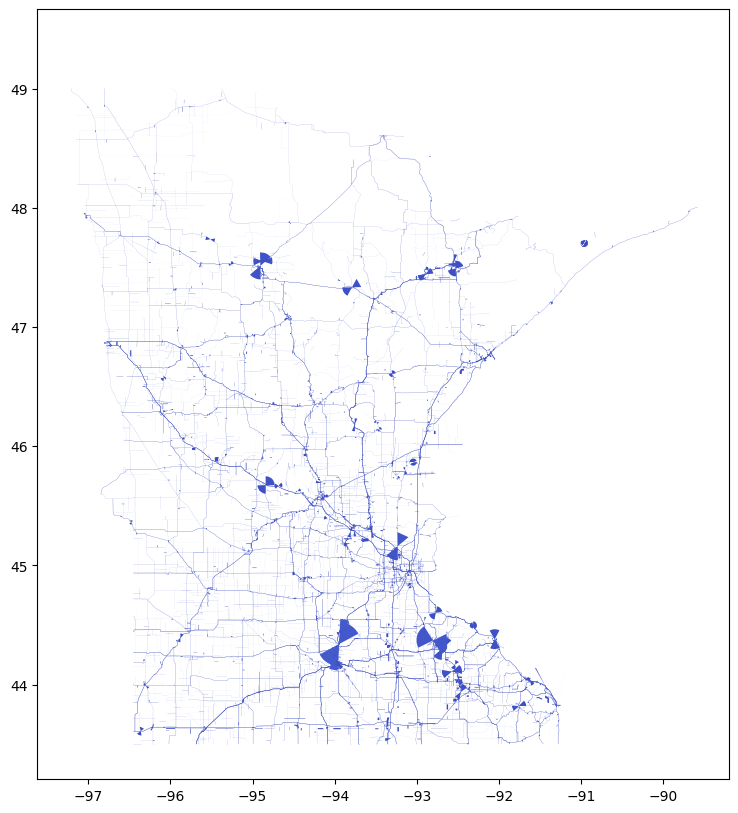

In [24]:
road_gdf.plot(column='accident_density', cmap='coolwarm', figsize=(10,10), linewidth=road_gdf['accident_density']*1000, vmin=0, vmax=1);

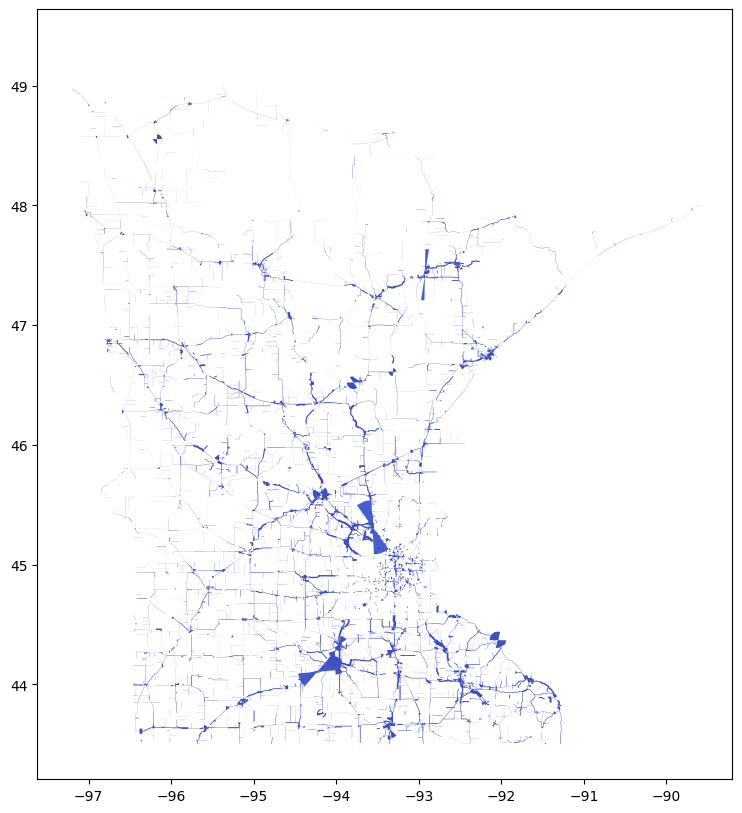

In [26]:
aadt_gdf.plot(column='accident_density', cmap='coolwarm', figsize=(10,10), linewidth=aadt_gdf['accident_density']*1000, vmin=0, vmax=1);

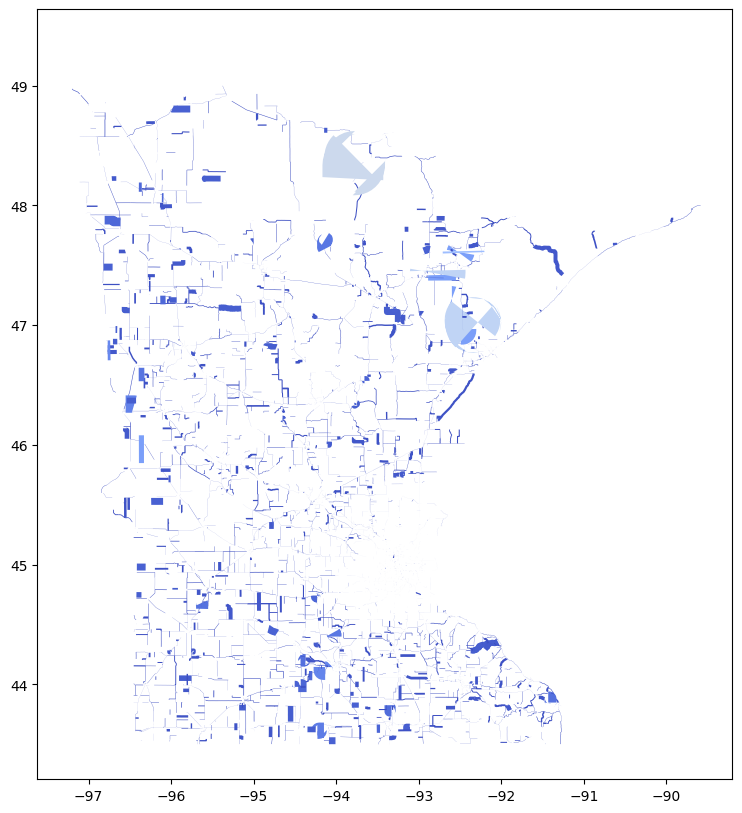

In [32]:
aadt_gdf.plot(column='acdnt_dens_by_aadt', cmap='coolwarm', figsize=(10,10), linewidth=aadt_gdf['acdnt_dens_by_aadt']*100, vmin=0, vmax=1);

### Spatial Stats

In [33]:
from pysal.explore import esda
from pysal.lib import weights

/Users/lukezaruba/miniconda3/envs/mnaccidents-env/lib/python3.9/site-packages/spaghetti/network.py:40: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


In [34]:
# Extract the points count as a NumPy array
data = road_gdf["accident_density"].values

# Create a weights matrix (W) for the spatial relationship between polygons
# You can use different methods to construct the weights matrix, e.g., queen or rook
w = weights.Queen.from_dataframe(road_gdf)

# Perform Local Moran's I analysis
moran_loc = esda.Moran_Local(data, w)

# Add the Local Moran's I values and p-values as columns in the GeoDataFrame
road_gdf['lmi_i'] = moran_loc.Is
road_gdf['lmi_p'] = moran_loc.p_sim
road_gdf['lmi_sig'] = 1 * (moran_loc.p_sim < 0.05)
road_gdf['lmi_q'] = moran_loc.q

# LABELS
labels = {
    0: "Non-Significant",
    1: "HH",
    2: "LH",
    3: "LL",
    4: "HL",
}
# Create column in `db` with labels for each polygon
road_gdf["lmi_label"] = pd.Series(
    moran_loc.q * (1 * (moran_loc.p_sim < 0.05)),
    index=road_gdf.index
).map(labels)

/Users/lukezaruba/miniconda3/envs/mnaccidents-env/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20722 disconnected components.
 There are 524 islands with ids: 125422, 142312, 145857, 145858, 156351, 190291, 190292, 198248, 198249, 200345, 200346, 221902, 221903, 229174, 231614, 235257, 246906, 263304, 263455, 263553, 263674, 263934, 263977, 264121, 264202, 264424, 264444, 264759, 264790, 265111, 265137, 265225, 265294, 265351, 265499, 265808, 265867, 266119, 266229, 266326, 266401, 266556, 267252, 267253, 267272, 267327, 267328, 267455, 267588, 267650, 267653, 268290, 268390, 268558, 268850, 268924, 269095, 269127, 269182, 269183, 269319, 269320, 269321, 269360, 269361, 269370, 269551, 269698, 269699, 269925, 270194, 270195, 270277, 270278, 270296, 270380, 270388, 270390, 270391, 270466, 270472, 270480, 270529, 270530, 270531, 270532, 270551, 270552, 270553, 270597, 270610, 270657, 270674, 270740, 27074

('WARNING: ', 125422, ' is an island (no neighbors)')
('WARNING: ', 142312, ' is an island (no neighbors)')
('WARNING: ', 145857, ' is an island (no neighbors)')
('WARNING: ', 145858, ' is an island (no neighbors)')
('WARNING: ', 156351, ' is an island (no neighbors)')
('WARNING: ', 190291, ' is an island (no neighbors)')
('WARNING: ', 190292, ' is an island (no neighbors)')
('WARNING: ', 198248, ' is an island (no neighbors)')
('WARNING: ', 198249, ' is an island (no neighbors)')
('WARNING: ', 200345, ' is an island (no neighbors)')
('WARNING: ', 200346, ' is an island (no neighbors)')
('WARNING: ', 221902, ' is an island (no neighbors)')
('WARNING: ', 221903, ' is an island (no neighbors)')
('WARNING: ', 229174, ' is an island (no neighbors)')
('WARNING: ', 231614, ' is an island (no neighbors)')
('WARNING: ', 235257, ' is an island (no neighbors)')
('WARNING: ', 246906, ' is an island (no neighbors)')
('WARNING: ', 263304, ' is an island (no neighbors)')
('WARNING: ', 263455, ' is a

(<Figure size 640x480 with 1 Axes>, <Axes: >)

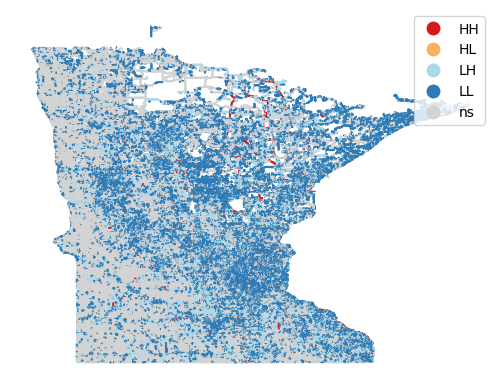

In [35]:
esdaplot.lisa_cluster(moran_loc, road_gdf, p=0.05)

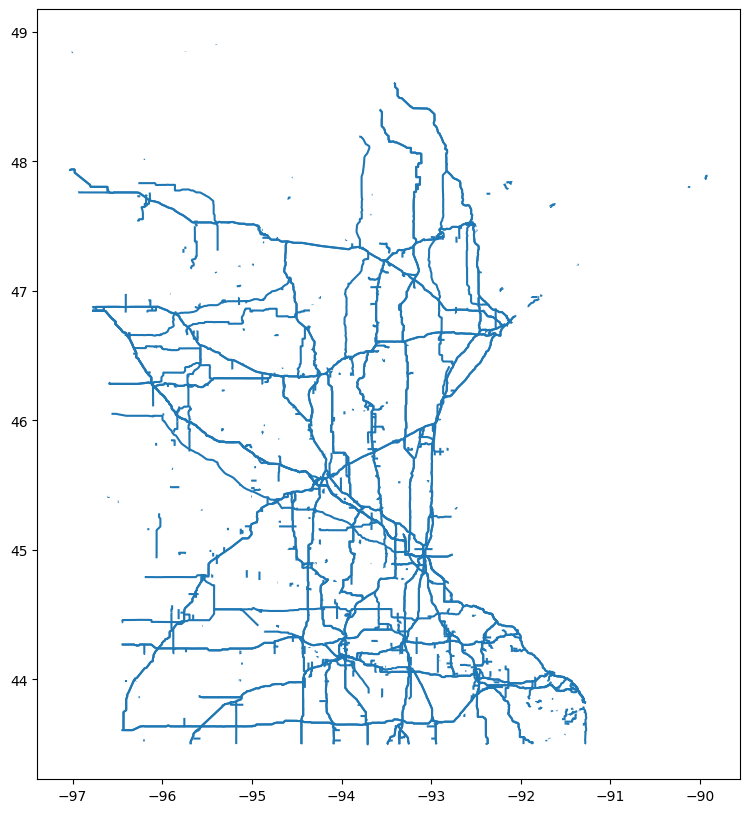

In [36]:
road_gdf.loc[road_gdf.lmi_label == "HH"].plot(figsize=(10,10));

##### AADT LISA

In [41]:
aadt_gdf

,ROUTE_LABE,STREET_NAM,LOCATION_D,VEHICLE_CL,DAILY_FACT,SEASONAL_F,AXLE_FACTO,CURRENT_YE,CURRENT_VO,AADT_COMME,DATA_TYPE,SHAPE_Leng,geometry,point_count,road_length,accident_density,acdnt_dens_by_aadt


In [40]:
#TODO:
aadt_gdf = aadt_gdf[aadt_gdf.geometry.type == "LINESTRING"]


# Extract the points count as a NumPy array
data_aadt = aadt_gdf["acdnt_dens_by_aadt"].values

# Create a weights matrix (W) for the spatial relationship between polygons
# You can use different methods to construct the weights matrix, e.g., queen or rook
w_aadt = weights.Queen.from_dataframe(aadt_gdf)

# Perform Local Moran's I analysis
moran_loc_aadt = esda.Moran_Local(data_aadt, w_aadt)

# Add the Local Moran's I values and p-values as columns in the GeoDataFrame
aadt_gdf['lmi_i'] = moran_loc_aadt.Is
aadt_gdf['lmi_p'] = moran_loc_aadt.p_sim
aadt_gdf['lmi_sig'] = 1 * (moran_loc_aadt.p_sim < 0.05)
aadt_gdf['lmi_q'] = moran_loc_aadt.q

# LABELS
labels_aadt = {
    0: "Non-Significant",
    1: "HH",
    2: "LH",
    3: "LL",
    4: "HL",
}
# Create column in `db` with labels for each polygon
aadt_gdf["lmi_label"] = pd.Series(
    moran_loc_aadt.q * (1 * (moran_loc_aadt.p_sim < 0.05)),
    index=aadt_gdf.index
).map(labels_aadt)

StopIteration: 

### FILTER AND COLOR BY ROAD CLASS
### SHORTEST PATH DISTANCE MATRIX FOR ABM/SPINT

### Network Analysis

In [49]:
# Create an empty NetworkX graph
G = nx.Graph()

road_gdf_exploded = road_gdf.explode()

# Iterate through the geodataframe and add nodes at line endpoints
for index, row in road_gdf_exploded.iterrows():
    start_node = (row['geometry'].coords[0])
    end_node = (row['geometry'].coords[-1])
    point_count = row['point_count']
    G.add_node(start_node)
    G.add_node(end_node)
    G.add_edge(start_node, end_node, point_count=point_count)

/var/folders/lj/t6r63s3x54x8r756999yfktr0000gn/T/ipykernel_42203/565702061.py:4: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  road_gdf_exploded = road_gdf.explode()


In [50]:
degree_centrality = nx.degree_centrality(G)

In [62]:
# # Get a list of centrality values (e.g., degree centrality with edge weights)
# centrality_values = list(degree_centrality.values())

# # Create a visualization with node size or edge thickness reflecting centrality values
# # Adjust the visualization based on your preferences
# plt.figure(figsize=(10, 8))
# nx.draw(G, 
#         pos=nx.spring_layout(G),  # Specify the layout for the graph (e.g., spring layout)
#         node_size=[v * 1000 for v in centrality_values],  # Adjust node size based on centrality with weights
#         with_labels=True,
#         cmap=plt.cm.RdYlBu,  # Color map
#         node_color=centrality_values,  # Node color based on centrality with weights
#         font_size=10,
#         font_color='black')
# plt.colorbar()  # Add a colorbar
# plt.title("Degree Centrality Visualization with Edge Weights")
# plt.show()

In [97]:
xList = []
yList = []
pcList = []
dcList = []

for key in degree_centrality:
    xList.append(key[0])
    yList.append(key[1])
    pcList.append(key[2])
    dcList.append(degree_centrality[key] * 100000)

df = pd.DataFrame({"X": xList, "Y": yList, "PC": pcList, "DC": dcList})

df

,X,Y,PC,DC
0,-93.353761,43.499463,0.0,0.322272
1,-92.061381,46.808704,0.0,0.644544
2,-93.353313,43.499471,0.0,0.322272
3,-92.061193,46.808814,0.0,1.289088
4,-93.283423,44.732322,0.0,0.322272
...,...,...,...,...
310293,-93.196241,45.196318,0.0,0.322272
310294,-93.195443,45.195269,0.0,0.322272
310295,-93.195396,45.196307,0.0,0.322272
310296,-93.193309,45.194910,0.0,0.322272


In [98]:
df.sort_values("DC")

,X,Y,PC,DC
0,-93.353761,43.499463,0.0,0.322272
204277,-93.204022,44.981213,0.0,0.322272
204280,-93.193904,44.978511,0.0,0.322272
204282,-93.189778,44.977158,0.0,0.322272
204283,-93.187968,44.975545,0.0,0.322272
...,...,...,...,...
10618,-93.348134,44.857956,0.0,1.933631
203273,-93.390533,44.936150,0.0,1.933631
178929,-93.409171,44.777665,0.0,1.933631
12627,-93.270534,44.969932,0.0,1.933631


In [ ]:
# PLOT & LOOK AT HIGH ACCIDENTS

### Community Detection

In [53]:
import community

# Detect communities using the Louvain method
partition = community.best_partition(G)

In [54]:
# Get the number of unique communities
num_communities = len(set(partition.values()))

# Generate a color map for communities
cmap = plt.get_cmap("viridis", num_communities)

# Create a list of unique community colors
community_colors = [cmap(i) for i in range(num_communities)]

# Create a list of colors for each node based on their community assignment
node_colors = [community_colors[partition[node]] for node in G.nodes()]

In [61]:
# Visualize the graph with nodes colored by their communities
# plt.figure(figsize=(10, 8))
# pos = nx.spring_layout(G)  # You can choose a different layout if needed
# nx.draw(G, pos, node_color=node_colors, node_size=100, cmap=plt.cm.viridis)
# plt.title("Community Detection Visualization")
# plt.show()

In [59]:
xList = []
yList = []
pcList = []
comList = []

for key in partition:
    xList.append(key[0])
    yList.append(key[1])
    pcList.append(key[2])
    comList.append(partition[key])

df = pd.DataFrame({"X": xList, "Y": yList, "PC": pcList, "COMM": comList})

df


,X,Y,PC,COMM
0,-93.353761,43.499463,0.0,0
1,-92.061381,46.808704,0.0,0
2,-93.353313,43.499471,0.0,0
3,-92.061193,46.808814,0.0,0
4,-93.283423,44.732322,0.0,1
...,...,...,...,...
310293,-93.196241,45.196318,0.0,3983
310294,-93.195443,45.195269,0.0,184
310295,-93.195396,45.196307,0.0,184
310296,-93.193309,45.194910,0.0,191


KeyError: 'COMM'

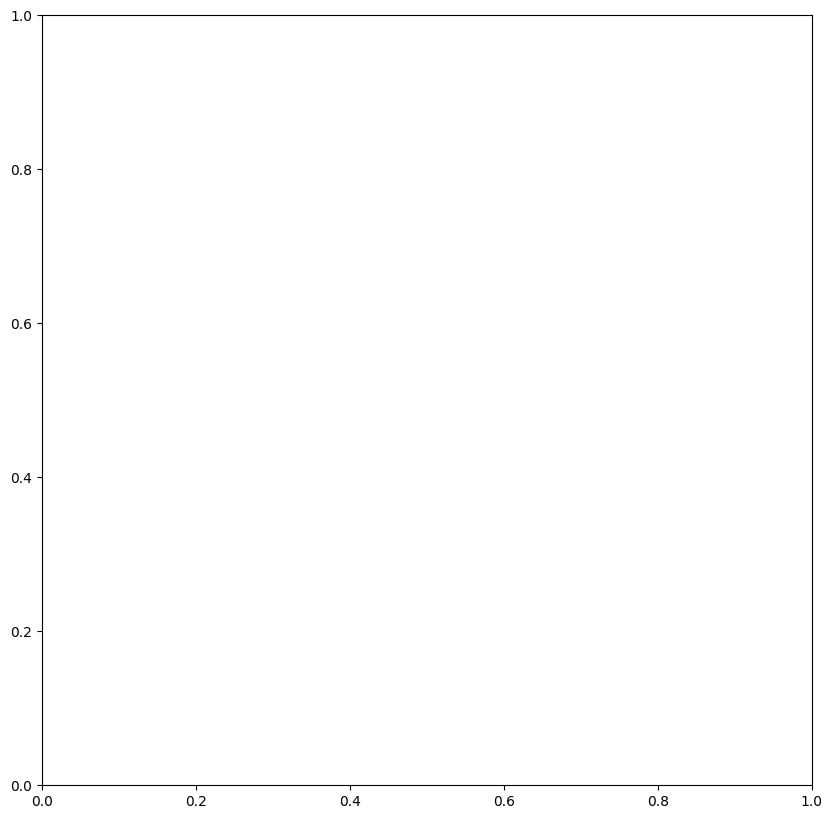

In [118]:
community_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['X'], df['Y']))

community_gdf.plot(column='COMM', cmap='turbo', figsize=(10,10));

In [90]:
community_counts = community_gdf.groupby('COMM').size().reset_index(name='count')

communities_gt_10 = community_counts[community_counts['count'] > 25]['COMM'].tolist()

filtered_community_gdf = community_gdf[community_gdf['COMM'].isin(communities_gt_10)]

filtered_community_gdf

,X,Y,PC,COMM,geometry
69,-94.088642,43.500066,0.0,23,POINT (-94.08864 43.50007)
70,-92.561436,47.519319,0.0,23,POINT (-92.56144 47.51932)
71,-92.561370,47.519103,0.0,23,POINT (-92.56137 47.51910)
80,-93.291771,44.311117,0.0,27,POINT (-93.29177 44.31112)
81,-93.093099,44.949723,0.0,27,POINT (-93.09310 44.94972)
...,...,...,...,...,...
307930,-93.246423,44.980963,0.0,1248,POINT (-93.24642 44.98096)
307931,-93.251256,44.986685,0.0,1248,POINT (-93.25126 44.98669)
307934,-93.274161,44.939525,0.0,4709,POINT (-93.27416 44.93953)
309242,-93.336120,44.946447,0.0,4444,POINT (-93.33612 44.94645)


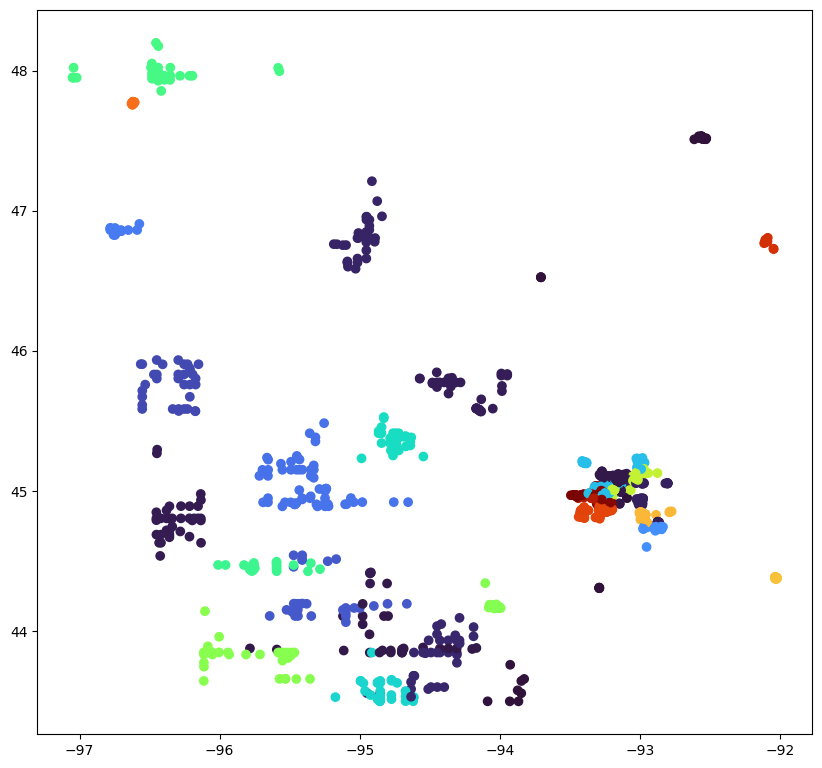

In [91]:
filtered_community_gdf.plot(column='COMM', cmap='turbo', figsize=(10,10));

### Data Mining

In [11]:
from sklearn.cluster import DBSCAN

In [14]:
# Change CRS for Length Calculation
road_gdf = road_gdf.to_crs("EPSG:3857")

# Calculate the length of each road segment
road_gdf['road_length'] = road_gdf['geometry'].length

# Normalize accident counts by road length
road_gdf['accident_density'] = road_gdf['point_count'] / road_gdf['road_length']

road_gdf = road_gdf.to_crs("EPSG:4326")

road_gdf.head()

,ROUTE_ID,ROUTE_LABE,ROUTE_SYST,ROUTE_SI_1,ROUTE_CARD,SHAPE_Leng,geometry,point_count,road_length,accident_density,X,Y
0,0100000000000035-D,I 35,01,Interstate,SB,417912.619886,"LINESTRING Z (-93.35376 43.49946 0.00000, -93....",67.0,594848.356144,0.000113,-1.035184e+07,5.666585e+06
1,0100000000000035-I,I 35,01,Interstate,NB,417858.422925,"LINESTRING Z (-93.35331 43.49947 0.00000, -93....",200.0,594773.623023,0.000336,-1.035178e+07,5.666612e+06
2,0100000000000035ED,I 35E,01,Interstate,SB,63932.829668,"LINESTRING Z (-93.28342 44.73232 0.00000, -93....",0.0,90477.850995,0.000000,-1.036578e+07,5.615987e+06
3,0100000000000035EI,I 35E,01,Interstate,NB,63468.500381,"LINESTRING Z (-93.28321 44.73672 0.00000, -93....",0.0,89824.109685,0.000000,-1.036556e+07,5.616344e+06
4,0100000000000035WD,I 35W,01,Interstate,SB,67697.218463,"LINESTRING Z (-93.28342 44.73232 0.00000, -93....",15.0,95848.171198,0.000156,-1.037668e+07,5.621074e+06


In [15]:
road_gdf['X'] = road_gdf['geometry'].centroid.x
road_gdf['Y'] = road_gdf['geometry'].centroid.y

road_gdf.head()

/var/folders/lj/t6r63s3x54x8r756999yfktr0000gn/T/ipykernel_46622/3084553813.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  road_gdf['X'] = road_gdf['geometry'].centroid.x
/var/folders/lj/t6r63s3x54x8r756999yfktr0000gn/T/ipykernel_46622/3084553813.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  road_gdf['Y'] = road_gdf['geometry'].centroid.y


,ROUTE_ID,ROUTE_LABE,ROUTE_SYST,ROUTE_SI_1,ROUTE_CARD,SHAPE_Leng,geometry,point_count,road_length,accident_density,X,Y
0,0100000000000035-D,I 35,01,Interstate,SB,417912.619886,"LINESTRING Z (-93.35376 43.49946 0.00000, -93....",67.0,594848.356144,0.000113,-92.974114,45.314366
1,0100000000000035-I,I 35,01,Interstate,NB,417858.422925,"LINESTRING Z (-93.35331 43.49947 0.00000, -93....",200.0,594773.623023,0.000336,-92.973550,45.314661
2,0100000000000035ED,I 35E,01,Interstate,SB,63932.829668,"LINESTRING Z (-93.28342 44.73232 0.00000, -93....",0.0,90477.850995,0.000000,-93.121499,44.956714
3,0100000000000035EI,I 35E,01,Interstate,NB,63468.500381,"LINESTRING Z (-93.28321 44.73672 0.00000, -93....",0.0,89824.109685,0.000000,-93.119556,44.958921
4,0100000000000035WD,I 35W,01,Interstate,SB,67697.218463,"LINESTRING Z (-93.28342 44.73232 0.00000, -93....",15.0,95848.171198,0.000156,-93.210451,45.005896


In [16]:
road_centroids = road_gdf[["ROUTE_ID", "point_count", "road_length", "accident_density", "X", "Y"]].copy()

road_centroids

,ROUTE_ID,point_count,road_length,accident_density,X,Y
0,0100000000000035-D,67.0,594848.356144,0.000113,-92.974114,45.314366
1,0100000000000035-I,200.0,594773.623023,0.000336,-92.973550,45.314661
2,0100000000000035ED,0.0,90477.850995,0.000000,-93.121499,44.956714
3,0100000000000035EI,0.0,89824.109685,0.000000,-93.119556,44.958921
4,0100000000000035WD,15.0,95848.171198,0.000156,-93.210451,45.005896
...,...,...,...,...,...,...
345525,1000023941831257-D,0.0,164.105089,0.000000,-93.195417,45.195788
345526,1000023941831258-I,0.0,278.294238,0.000000,-93.193719,45.195710
345527,1000023941831258-D,0.0,278.294238,0.000000,-93.193719,45.195710
345528,2200006594720105-I,0.0,34.005743,0.000000,-93.502043,44.971104


In [17]:
# Create DBSCAN Model
def dbscanModel(df, ep=0.001, minSamp=10):
    # Create Model
    model = DBSCAN(eps=ep, min_samples=minSamp)
    
    # Fit Model
    model.fit(df[["X", "Y", "accident_density"]])

    # Add Labels to DF
    df["labels"] = model.labels_

    # Filter out Noise
    dfNoiseFree = df.loc[df.labels != -1]

    # Convert Labels to Strings for Easy Display
    dfNoiseFree["labels"] = dfNoiseFree["labels"].astype(str)
    
    return dfNoiseFree, df

In [18]:
modelDF, modelDF_wNoise = dbscanModel(road_centroids)

/var/folders/lj/t6r63s3x54x8r756999yfktr0000gn/T/ipykernel_46622/248886411.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfNoiseFree["labels"] = dfNoiseFree["labels"].astype(str)


In [25]:
dbscan_groups = modelDF_wNoise.loc[modelDF_wNoise.labels != -1].groupby('labels').size().reset_index(name='count')

dbscan_groups.sort_values("count")

,labels,count
446,446,6
716,716,6
360,360,8
714,714,8
513,513,8
...,...,...
279,279,50
474,474,50
251,251,54
70,70,84


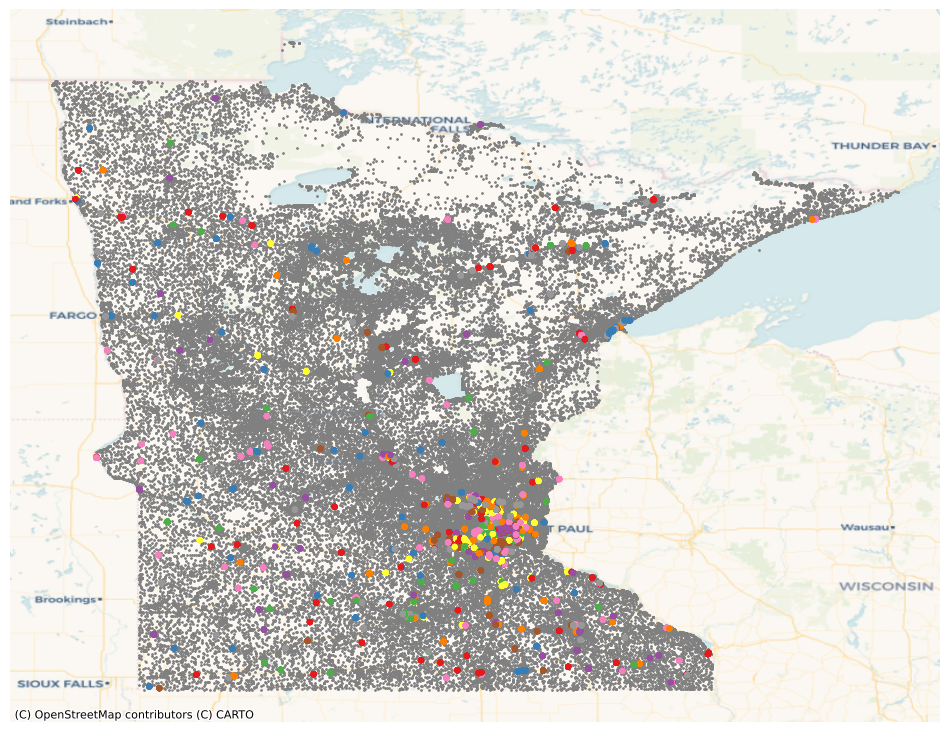

In [20]:
# Set up Fig
f, ax = plt.subplots(1, figsize=(12, 12))

# Plot Noise
noise = modelDF_wNoise.loc[modelDF_wNoise.labels == -1]
ax.scatter(noise["X"], noise["Y"], c = "grey", s = 3, linewidth = 0)

# Plot Clusters
ax.scatter(modelDF_wNoise.loc[modelDF_wNoise.index.difference(noise.index), "X"],
    modelDF_wNoise.loc[modelDF_wNoise.index.difference(noise.index), "Y"],
    #c = "Blue",
    c = modelDF_wNoise.loc[modelDF_wNoise.index.difference(noise.index), "labels"],
    cmap = "Set1",
    s = 20,
    linewidth = 0,
)

ax.scatter(modelDF_wNoise.loc[modelDF_wNoise.index.i(noise.index), "X"],
    modelDF_wNoise.loc[modelDF_wNoise.index.difference(noise.index), "Y"],
    #c = "Blue",
    c = modelDF_wNoise.loc[modelDF_wNoise.index.difference(noise.index), "labels"],
    cmap = "Set1",
    s = 20,
    linewidth = 0,
)

# Add Basemap
contextily.add_basemap(ax, source = contextily.providers.CartoDB.Voyager, crs = "EPSG:4326")

ax.set_axis_off()

# Displaying plot
plt.show()